In [13]:
import sys
import numpy as np
sys.path.append('../../../nn')
from mynn import *
from mydata import *

from Adam import Adam
import operator
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from timeit import default_timer
import numpy as np

from torch.autograd import Variable


torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
M_  = [312*(2**i) for i in range(6)]

M  = M_[0]

N = 100

ntrain = M//2
acc = 0.99

xgrid = np.linspace(0,1,N+1)
dx    = xgrid[1] - xgrid[0]


(Text(0.5, 0, 'x'), Text(0.5, 1.0, 'u(x,y)'))

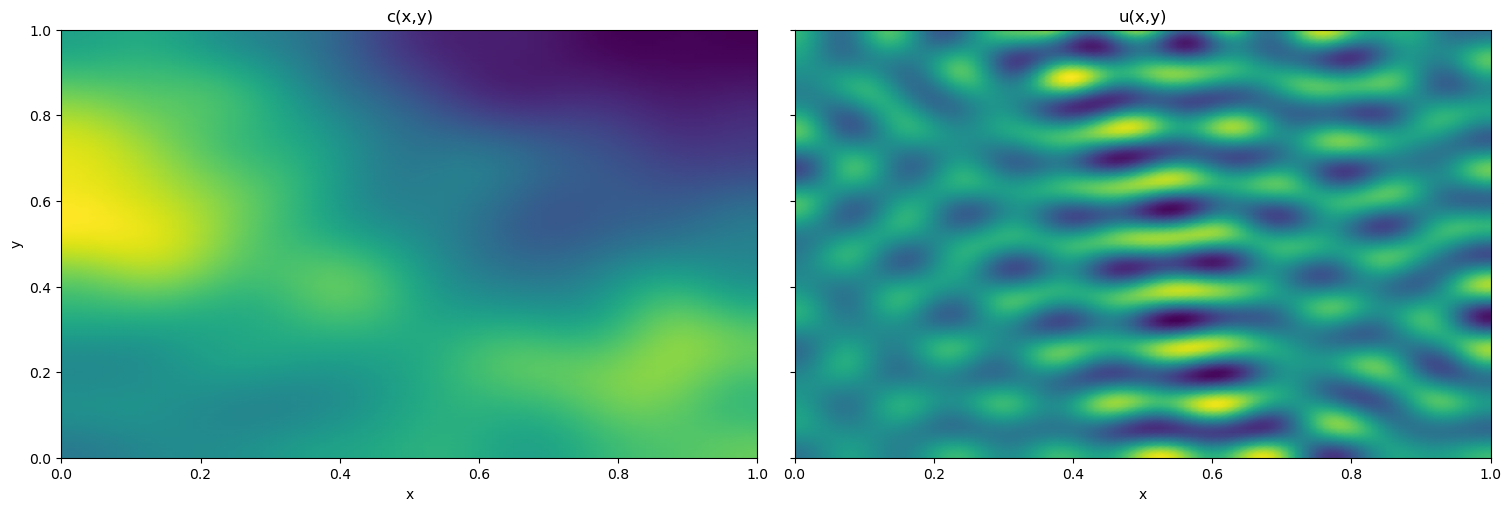

In [15]:
xgrid = np.linspace(0,1,N+1)
Y, X = np.meshgrid(xgrid, xgrid)

inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
outputs = np.load("../../../../data/Helmholtz_outputs.npy")   

_, axs = plt.subplots(1, 2,figsize = (15,5), layout='constrained', sharey=True)
axs[0].pcolormesh(X, Y, inputs[:,:,0], shading="gouraud")
axs[0].set_xlabel("x"), axs[0].set_ylabel("y"), axs[0].set_title("c(x,y)")


axs[1].pcolormesh(X, Y, outputs[:,:,0], shading="gouraud")
axs[1].set_xlabel("x"), axs[1].set_title("u(x,y)")


In [16]:
# compute_input_PCA = True

# if compute_input_PCA:
#     train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
#     # test_inputs  = np.reshape(inputs[:,:,M//2:M], (-1, M-M//2))
#     Ui,Si,Vi = np.linalg.svd(train_inputs)
#     en_f= 1 - np.cumsum(Si)/np.sum(Si)
#     r_f = np.argwhere(en_f<(1-acc))[0,0]
#     r_f = min(r_f, 512)
#     print("Energy is ", en_f[r_f - 1])
#     Uf = Ui[:,:r_f]
#     f_hat = np.matmul(Uf.T,train_inputs)
#     x_train_part = f_hat.T.astype(np.float32)
#else:
    
    # train_inputs =  theta[:M//2, :]
    # # test_inputs  = theta[M//2:M, :]
    # r_f = N_theta
    # x_train_part = train_inputs.astype(np.float32)

# del train_inputs
# del inputs
# del Ui, Vi, Uf, f_hat

In [17]:
Y, X = np.meshgrid(xgrid, xgrid)
# test
i = 20
j = 40
assert(X[i, j] == i*dx and Y[i, j] == j*dx)

# X_upper = full2upper(X)
# Y_upper = full2upper(Y)
# N_upper = len(X_upper)
# x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
# y_train = np.zeros(M//2 * N_upper, dtype = np.float32)

X_upper = np.reshape(X, -1)
Y_upper = np.reshape(Y, -1)
N_upper = len(X_upper)
#x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
x_train = np.zeros((M//2 * N_upper, 3), dtype = np.float32)
y_train = np.zeros(M//2 * N_upper, dtype = np.float32)

In [18]:
# for i in range(M//2):
#     d_range = range(i*N_upper, (i + 1)*N_upper)
#     x_train[d_range , 0:r_f]   = x_train_part[i, :]
#     x_train[d_range , r_f]     = X_upper
#     x_train[d_range , r_f + 1] = Y_upper 
#     y_train[d_range] = np.reshape(outputs[:, :, i], -1)

for i in range(M//2):
    d_range = range(i*N_upper, (i + 1)*N_upper)
    x_train[d_range , 0]   = np.reshape(inputs[:, :, i], -1)
    x_train[d_range , 1]     = X_upper
    x_train[d_range , 2] = Y_upper 
    y_train[d_range] = np.reshape(outputs[:, :, i], -1)


#print("Input dim : ", r_f+2, " output dim : ", 1)

In [19]:
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(-1)

# x_normalizer = UnitGaussianNormalizer(x_train)
# x_normalizer.encode_(x_train)
# y_normalizer = UnitGaussianNormalizer(y_train)
# y_normalizer.encode_(y_train)

In [20]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

In [21]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_y = torch.autograd.grad(
        du[:,-1],data_domain, 
        grad_outputs=torch.ones_like(du[:,-1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddu_x = torch.autograd.grad(
        du[:,-2],data_domain, 
        grad_outputs=torch.ones_like(du[:,-2]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = -ddu_x[:,-2].reshape(-1,1)-ddu_y[:,-1].reshape(-1,1) - (10e3/data_domain[:,0].reshape(-1,1))*u.reshape(-1,1)
    return f

def bc_b(self,data_bc):
    data_bc = torch.cat ([data_bc[:,:2],torch.zeros((data_bc.shape[0],1),requires_grad=True) ],axis =1)
    u = self(data_bc)

    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return du[:,-2].reshape(-1,1)

def bc_l(self,data_bc):
    data_bc = torch.cat ([data_bc[:,0].reshape(-1,1),torch.zeros((data_bc.shape[0],1),requires_grad=True), data_bc[:,2].reshape(-1,1)],axis =1)

    u = self(data_bc)
    
    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return du[:,-1].reshape(-1,1)

def bc_r(self,data_bc):
    data_bc = torch.cat ([data_bc[:,0].reshape(-1,1),torch.ones((data_bc.shape[0],1),requires_grad=True), data_bc[:,2].reshape(-1,1)],axis =1)

    u = self(data_bc)
    
    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return du[:,-1].reshape(-1,1)


def bc_u(self,data_bc):
    data_bc = torch.cat ([data_bc[:,:2],torch.ones((data_bc.shape[0],1),requires_grad=True) ],axis =1)

    u = self(data_bc)
    
    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    f = torch.where((data_bc[:,1 ] > 0.35) & (data_bc[:,1 ] < 0.65), 1, 0)
    return du[:,-2].reshape(-1,1) - f.reshape(-1,1)

FNN.de = de
FNN.bc_b = bc_b
FNN.bc_l = bc_l
FNN.bc_r = bc_r
FNN.bc_u = bc_u

In [22]:
learning_rate = 0.001

epochs = 200
#epochs = 1

step_size = 100
gamma = 0.5

N_neurons = 16
layers = 4

model = FNN(3, 1, layers, N_neurons) 
print(count_params(model))
model.to(device)

625


FNN(
  (modus): ModuleDict(
    (LinM1): Linear(in_features=3, out_features=16, bias=True)
    (NonM1): ReLU()
    (LinM2): Linear(in_features=16, out_features=16, bias=True)
    (NonM2): ReLU()
    (LinM3): Linear(in_features=16, out_features=16, bias=True)
    (NonM3): ReLU()
    (LinMout): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [23]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
#####
#y_normalizer.cpu()
t0 = default_timer()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        #x, y = x.cuda(), y.cuda()
        x = Variable(x,requires_grad=True)

        #batch_size_ = x.shape[0]
        optimizer.zero_grad()
        out = model(x)
        #out = y_normalizer.decode(out)
        #y = y_normalizer.decode(y)
        de_pred = model.de(x)
        left_bc_pred,right_uc_pred =  model.bc_b(x),model.bc_u(x)
        left_lc_pred,right_rc_pred = model.bc_l(x),model.bc_r(x)

        loss_pde = myloss(de_pred,torch.zeros_like(out))
        loss_bc,loss_uc = myloss(left_bc_pred,torch.zeros_like(out)), myloss(right_uc_pred,torch.zeros_like(out))
        loss_lc,loss_rc = myloss(left_lc_pred,torch.zeros_like(out)),myloss(right_rc_pred,torch.zeros_like(out))


        loss = myloss(out , y)
        Loss = loss +loss_pde + loss_bc + loss_uc + loss_lc + loss_rc
        #Loss = loss
        Loss.backward()

        optimizer.step()
        train_l2 += Loss.item()

    #torch.save(model, "DeepONetNet_"+str(N_neurons)+"Nd_"+str(ntrain)+".model")
    scheduler.step()

    train_l2/= ntrain

    t2 = default_timer()
    print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)

Epoch :  0  Epoch time :  58.762497744999564  Train L2 Loss :  48221.283802986145


KeyboardInterrupt: 

In [12]:
torch.save(model, "ParaNet"+str(N_neurons)+"Nd_"+str(ntrain)+".model")

In [1]:
import sys
import numpy as np
from mynn import *
from mydata import *

from Adam import Adam
import operator
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from timeit import default_timer
import numpy as np

torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#M_  = [312*(2**i) for i in range(6)]
for M in [312,624]:
    N = 100

    ntrain = M//2
    ntest = M-M//2
    s = N+1
    acc = 0.99

    xgrid = np.linspace(0,1,N+1)
    dx    = xgrid[1] - xgrid[0]



    inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
    outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

    inputs = inputs.transpose(2, 0, 1)
    outputs = outputs.transpose(2, 0, 1)
 

    x_train = torch.from_numpy(np.reshape(inputs[:M//2, :, :], -1).astype(np.float32))
    y_train = torch.from_numpy(np.reshape(outputs[:M//2, :, :], -1).astype(np.float32))

    x_test = torch.from_numpy(np.reshape(inputs[M//2:M, :, :], -1).astype(np.float32))
    y_test = torch.from_numpy(np.reshape(outputs[M//2:M, :, :], -1).astype(np.float32))

    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

    y_normalizer = UnitGaussianNormalizer(y_train)
    y_train = y_normalizer.encode(y_train)


    x_train = x_train.reshape(ntrain,s,s,1)
    x_test = x_test.reshape(ntest,s,s,1)

    # todo do we need this
    y_train = y_train.reshape(ntrain,s,s,1)
    y_test = y_test.reshape(ntest,s,s,1)



    batch_size = 1024

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)


    learning_rate = 0.001

    epochs = 2

    step_size = 100
    gamma = 0.5

    #modes = [2,4,8,16,32]
    modes =[2]

    #N_neurons = [16,64,128,256]
    N_neurons = [16]
    for nneurons, mode in zip(N_neurons,modes):

        model = FNO2d(mode, mode, nneurons)
        print(count_params(model))
        model.to(device)

        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        myloss = torch.nn.MSELoss(reduction='sum')
        #####
        #y_normalizer.cuda()
        #y_normalizer.cpu()
        t0 = default_timer()
        for ep in range(epochs):
            model.train()
            t1 = default_timer()
            train_l2 = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                batch_size_ = x.shape[0]
                optimizer.zero_grad()
                out = model(x).reshape(batch_size_, s, s)
                out = y_normalizer.decode(out)
                y = y_normalizer.decode(y)

                loss = myloss(out.view(batch_size_,-1), y.view(batch_size_,-1))
                loss.backward()

                optimizer.step()
                train_l2 += loss.item()

            scheduler.step()

            train_l2/= ntrain

            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Rel. Train L2 Loss : ", train_l2)

        print("Total time is :", default_timer() - t0, "Total epoch is ", epochs)
        torch.save(model, "FNO_"+str(nneurons)+"Nd_"+str(ntrain)+".model")


7009
Epoch :  0  Epoch time :  1.4406127759993979  Rel. Train L2 Loss :  1.3924766931778345
Epoch :  1  Epoch time :  1.4450069049999001  Rel. Train L2 Loss :  1.3870304792355268
Total time is : 2.8857747059992107 Total epoch is  2
7009
Epoch :  0  Epoch time :  2.784535010999207  Rel. Train L2 Loss :  1.4326537694686499
Epoch :  1  Epoch time :  2.7810736869996617  Rel. Train L2 Loss :  1.4232743092072315
Total time is : 5.565768857999501 Total epoch is  2
